Pretraining is the first step of the BERT framework, which can be broken down into two sub-steps:

• Defining the model’s architecture: number of layers, number of heads, dimensions, and the other building blocks of the model.

• Training the model on MLM and NSP tasks.

---

The second step of the BERT framework is fine-tuning, which can also be broken down into two 
sub-steps:

• Initializing the downstream model chosen with the trained parameters of the pretrained 
BERT model

• Fine-tuning the parameters for specific downstream tasks such as Recognizing Textual 
Entailment (RTE), question answering (SQuAD v1.1, SQuAD v2.0), and Situations With Adversarial Generations (SWAG)

In [1]:
import io
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

%matplotlib inline
warnings.filterwarnings('ignore')

2023-02-06 18:55:59.743116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 18:56:03.481892: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-06 18:56:03.482922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-06 18:56:03.482935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
#Load the dataset.
import os

!curl -L 'https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/in_domain_train.tsv' --output "in_domain_train.tsv"

!curl -L 'https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/out_of_domain_dev.tsv' --output  "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1938k      0 --:--:-- --:--:-- --:--:-- 1938k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0   101k      0 --:--:-- --:--:-- --:--:--  102k


In [4]:
df = pd.read_csv('in_domain_train.tsv', delimiter = '\t', header = None, 
                 names = ['sentence_source', 'label', 'label_notes', 'sentence'])
df.sample(5)

,sentence_source,label,label_notes,sentence
3013,l-93,1,NaN,they praised the volunteers .
7093,sgww85,0,*,"john drinks coffee at 11 , and mary , tea at 1..."
8007,ad03,1,NaN,keep yourself clean !
3899,ks08,1,NaN,john deposited some money in the bank on friday .
1396,r-67,1,NaN,who are you trying to get hold of ?


In [5]:
#Create sentences, label lists and adding bert tokens.
sentences = df.sentence.values

sentences = ["[CLS]" + sentence + "[SEP]" for sentence in sentences]
labels = df.label.values

In [6]:
#Activating the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print('Tokenize the first sentence.')
print(tokenized_texts[0])

Tokenize the first sentence.
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [7]:
#Data processing.
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

#Pad input tokens.
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = 'long', truncating = 'post', 
                          padding = 'post')

In [8]:
#Create attention masks.
attention_masks = []

#Create a mask of 1s for each token followed by 0s for padding.
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

In [9]:
#Split data into train and validation splits.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state = 420, test_size = 0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=420, test_size = 0.1)


#Convert data into torch tensors.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

#Select batch size and creating an iterator.
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

In [10]:
#BERT model config.
from transformers import BertModel, BertConfig
configuration = BertConfig()

#Initialize a model for the bert-base-uncased style config.
model = BertModel(configuration)

configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [11]:
#Load the HuggingFace BERT uncased base model.
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)
model = nn.DataParallel(model)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=Tru

In [12]:
#Prepare model's parameter for the training loop.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
epochs = 4

optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.1},
                                
                                #Filter for parameters which *do* include those.
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.0}]

optimizer = AdamW(optimizer_grouped_parameters, lr = 2e-5, eps = 1e-8)

total_steps = len(train_dataloader) * epochs

#Create a learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps= total_steps)

# Add accuracy measurement.
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
#@title The Training Loop
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs['loss']
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
    
    
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.7247247695922852
Train loss: 0.693417489528656
Train loss: 0.686937669912974
Train loss: 0.6490570604801178
Train loss: 0.6490564703941345
Train loss: 0.6299187441666921
Train loss: 0.6121832132339478
Train loss: 0.6276096701622009
Train loss: 0.6253509985076057
Train loss: 0.6192360043525695
Train loss: 0.6237839568745006
Train loss: 0.6311295678218206
Train loss: 0.6322599236781781
Train loss: 0.6255822139126914
Train loss: 0.6153660853703816
Train loss: 0.6069525722414255
Train loss: 0.6050800733706531
Train loss: 0.6097062743372388
Train loss: 0.6085247758187746
Train loss: 0.6082040622830391
Train loss: 0.6057561933994293
Train loss: 0.6036902246150103
Train loss: 0.6006441336611043
Train loss: 0.598572469005982
Train loss: 0.5954930555820465
Train loss: 0.5955301763919684
Train loss: 0.5946055087778304
Train loss: 0.5998905482036727
Train loss: 0.6025915464450573
Train loss: 0.6019009699424108
Train loss: 0.6034680941412526
Train loss: 0.6090331086888909
Train loss:

Epoch:  25%|██▌       | 1/4 [43:37<2:10:51, 2617.06s/it]

Validation Accuracy: 0.810570987654321
Train loss: 0.21653392910957336
Train loss: 0.27876220643520355
Train loss: 0.3128736714522044
Train loss: 0.31476903706789017
Train loss: 0.30998932123184203
Train loss: 0.30304255584875744
Train loss: 0.29733445388930185
Train loss: 0.29397808015346527
Train loss: 0.2999105519718594
Train loss: 0.29084333330392836
Train loss: 0.2958936108784242
Train loss: 0.30402715876698494
Train loss: 0.29444158994234526
Train loss: 0.30236593527453287
Train loss: 0.30337560971577965
Train loss: 0.2966208253055811
Train loss: 0.3060581193250768
Train loss: 0.3122565928432677
Train loss: 0.3118743990596972
Train loss: 0.31261658370494844
Train loss: 0.32929032757168725
Train loss: 0.32676768709312787
Train loss: 0.3194859533206276
Train loss: 0.32194265102346736
Train loss: 0.31783107995986937
Train loss: 0.3195265336678578
Train loss: 0.3160511983765496
Train loss: 0.31656970190150396
Train loss: 0.3169410927542325
Train loss: 0.3146854216853778
Train loss: 0

Epoch:  50%|█████     | 2/4 [1:27:05<1:27:04, 2612.26s/it]

Validation Accuracy: 0.82445987654321
Train loss: 0.1299155205488205
Train loss: 0.14886675775051117
Train loss: 0.14284956455230713
Train loss: 0.1810874566435814
Train loss: 0.18239376246929168
Train loss: 0.17745147893826166
Train loss: 0.18391177696841104
Train loss: 0.1927181202918291
Train loss: 0.19146973060237038
Train loss: 0.18716650307178498
Train loss: 0.18339207497510043
Train loss: 0.17792555751899877
Train loss: 0.1840107079881888
Train loss: 0.1907594060259206
Train loss: 0.18510442823171616
Train loss: 0.17978496057912707
Train loss: 0.17627592735430775
Train loss: 0.17450971239142948
Train loss: 0.17685250467375704
Train loss: 0.1911124385893345
Train loss: 0.18946817162491025
Train loss: 0.18666116486896167
Train loss: 0.18576489453730377
Train loss: 0.1899772398173809
Train loss: 0.1883968496322632
Train loss: 0.18744794393961245
Train loss: 0.1913120531373554
Train loss: 0.1930023075214454
Train loss: 0.19021365920017505
Train loss: 0.18721123412251472
Train loss: 

Epoch:  75%|███████▌  | 3/4 [2:10:38<43:32, 2612.29s/it]  

Validation Accuracy: 0.8410493827160493
Train loss: 0.060087382793426514
Train loss: 0.07616754248738289
Train loss: 0.08538610239823659
Train loss: 0.1236201748251915
Train loss: 0.12509560585021973
Train loss: 0.12233946720759074
Train loss: 0.1156769288437707
Train loss: 0.10348283895291388
Train loss: 0.10474285007350975
Train loss: 0.10887783635407686
Train loss: 0.10161420448937199
Train loss: 0.09735826480512817
Train loss: 0.09291035123169422
Train loss: 0.0898627642808216
Train loss: 0.08771769168476264
Train loss: 0.08723408507648855
Train loss: 0.10331613493754584
Train loss: 0.10529045315666331
Train loss: 0.10865784054131884
Train loss: 0.10691990265622735
Train loss: 0.10683142792965684
Train loss: 0.10414758316156539
Train loss: 0.10103989675964999
Train loss: 0.09807503580426176
Train loss: 0.09625611409544944
Train loss: 0.09663664907790147
Train loss: 0.0975731731288963
Train loss: 0.0970708452431219
Train loss: 0.09508147116365104
Train loss: 0.09786932518084844
Trai

Epoch: 100%|██████████| 4/4 [2:54:13<00:00, 2613.29s/it]

Validation Accuracy: 0.8275462962962963


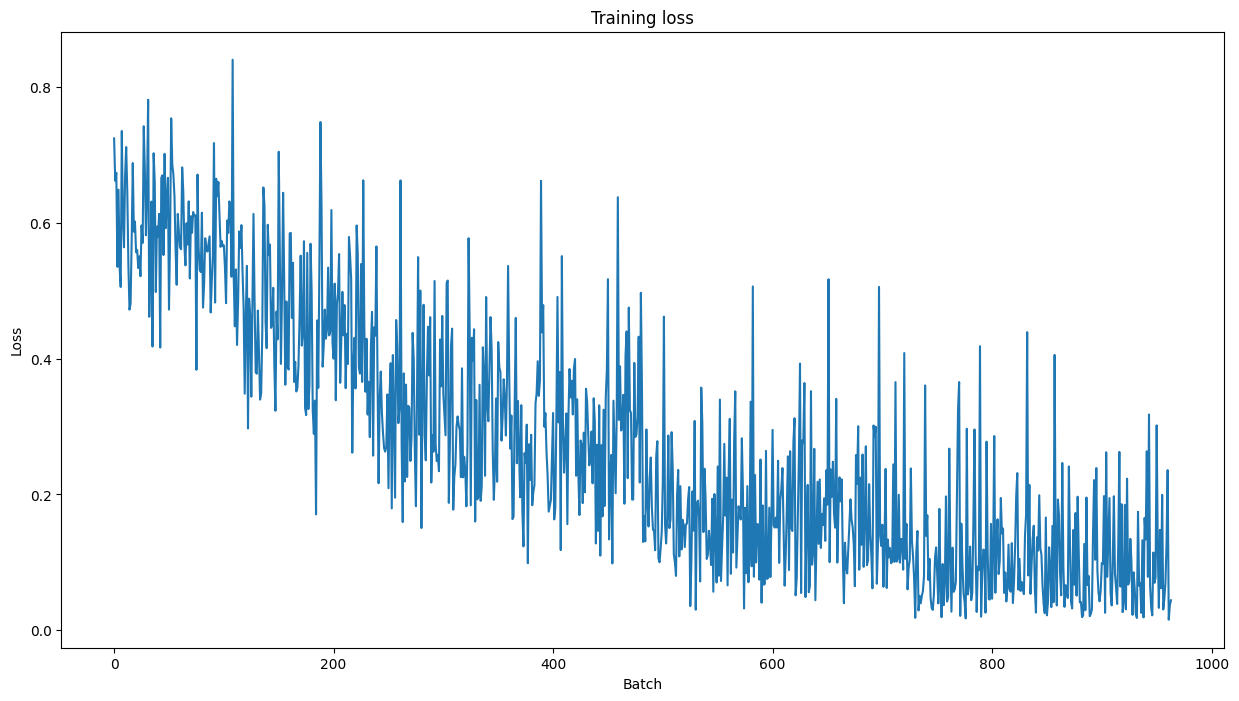

In [16]:
#@title Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [18]:
#@title Predicting and Evaluating Using the Hold-out Dataset 
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [19]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
    # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

In [20]:
#@title Evaluating Using Matthew's Correlation Coefficient
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)

In [21]:
#@title Matthew's Evaluation on the Whole Dataset
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5187749525301079

In [22]:
type(model)

torch.nn.parallel.data_parallel.DataParallel

In [23]:
PATH = "bert-sentiment.pt"

# Save
torch.save(model.state_dict(), PATH)